In [1]:
import calim
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.patches as mpatches
import seaborn as sns
import pickle
import pandas as pd
import numpy as np
from datetime import datetime
import scipy
from scipy import stats
from scipy.stats import sem




n_boot = 10000
seed = 10

In [2]:
color_palette = sns.color_palette("colorblind")
sns.set_theme(palette=color_palette, font="Arial", font_scale=1.0, style="white")

In [3]:
#styles for error and markers in sns.lineplot

thin_custom_lw = 1.2
custom_lw = thin_custom_lw/0.65

filled_marker_style = dict(marker='o',  markersize=5,
                           color='k',
                           markerfacecolor='w',
                           markeredgecolor='k',
                          markeredgewidth=thin_custom_lw)

filled_marker_style_white = dict(marker='o',  markersize=5,
                           color='w',
                           markerfacecolor='w',
                           markeredgecolor='w',
                          markeredgewidth=custom_lw)
######################

error_style_white = {"capsize": 4.4, 
                "ecolor": "w",
               "barsabove":False, 
               "elinewidth":custom_lw, 
               "capthick":custom_lw,
                    "zorder": 8}

error_style = {"capsize": 4, 
                "ecolor": "k",
                "barsabove":False, 
                "elinewidth":thin_custom_lw, 
                "capthick":thin_custom_lw,
                "zorder": 9}


In [4]:
#Calibration of Scientifica-Setup (19.05.2021)
kd = 417.1324107961717
R_max = 1.9267297757725788*1.305670312829699
R_min = 0.27585714285714286*0.8222568831620652
sf2_by_sb2 = 2273/413



def calcium(data, kd, R_max, R_min, sf2_by_sb2):
    return kd*((data-R_min)/(R_max-data))*sf2_by_sb2

In [5]:
# Names of used data files

filename_1 = "doppel_perf_fura_data+ctrl_230313.hdf" 

In [6]:
# import data

data_pkl_1 = calim.Project()
data_pkl_1.from_hdf(filename_1)

In [7]:
# Process recordings from data files
# The DataFrame "conditions" will contain all information about conditions
# data is "start corrected"
data_1 = pd.DataFrame()
print(f"Processing recordings contained in {filename_1}:")

for recording in data_pkl_1.recordings:
    print(recording)
    
    r = data_pkl_1.recordings[recording]

    info = {desc: r.information[desc] for desc in r.information}
    
    for cell in r.cells:
        c = r.cells[cell]
        
        if c.use:

            for con in r.conditions:
                info["recording"] = recording
                info["start"] = int(con.start)
                info["end"] = int(con.end)
                info["cell"] = cell
                info["dt"] = r.dt # Add "dt" aka seconds/frame
                info["date"] = info["recording"][0:6]
                
                info["start_add"] = int(120/r.dt) #amount of frames to be added to start
                info.update({desc: con.information[desc] for desc in con.information}) # Add all further condition variables
                
                info["mean_raw"] = c.raw_data[info["start"]:info["end"]].mean()
                info["mean_raw_corr"] = c.raw_data[info["start"]+info["start_add"]:info["end"]].mean()
        
                info["mean_ca"] = calcium(c.raw_data[info["start"]:info["end"]], kd, R_max, R_min, sf2_by_sb2).mean()
                info["mean_ca_corr"] = calcium(c.raw_data[info["start"]+info["start_add"]:info["end"]], kd, R_max, R_min, sf2_by_sb2).mean()                    
                
                info["start_steady_state"] = int(con.end) - int(240/r.dt) #amount of frames to be deducted from end,  3 min
                info["mean_ca_steady_state"] = calcium(c.raw_data[info["start_steady_state"]:info["end"]], kd, R_max, R_min, sf2_by_sb2).mean()
                
                
                info["raw_data_con"] = c.raw_data[info["start"]:info["end"]]
                info["raw_data_con_corr"] = c.raw_data[info["start"]+info["start_add"]:info["end"]]
                
                #data_1 = data_1.append(pd.Series(info), ignore_index=True)
                data_1 = pd.concat((data_1, pd.DataFrame.from_dict(info, orient="index").T), ignore_index=True)
                
                
data_1=data_1.astype({'angiotensin': 'int64'})
data_1=data_1.astype({'pos': 'int64'})
data_1=data_1.astype({'potassium': 'float64'})
data_1=data_1.astype({'mean_ca_corr': 'float64'})
data_1=data_1.astype({'mean_ca_steady_state': 'float64'})

data_1["pos_mod"] = data_1["pos"]-1


print("Done.")
now = datetime.now().strftime("%d-%b-%Y %H:%M")
print("###### date and time ######")
print(now)

Processing recordings contained in doppel_perf_fura_data+ctrl_230313.hdf:
230223_slice03_ttap2_isra_ctrl_results.csv
230223_slice04_ttap2_isra_results.csv
230224_slice01_ttap2_isra_ctrl_results.csv
230224_slice04_ttap2_isra_results.csv
230224_slice06_ttap2_isra_ctrl_results.csv
230227_slice03_ttap2_isra_results.csv
230227_slice04_ttap2_isra_ctrl_results.csv
230228_slice03_ttap2_isra_results.csv
230228_slice04_ttap2_isra_ctrl_results.csv
230302_slice08_ttap2_isra_results.csv
Done.
###### date and time ######
09-Jun-2023 17:09


In [8]:
# keep recording with at least 6 cells 
drop_rec = data_1[data_1["pos"]==1]\
            .groupby(["recording"])\
            .count().reset_index().query("cell<6").recording.unique()
data_1 = data_1[~data_1.recording.isin(drop_rec)]

In [9]:
### calculate relative mean concentratio (mean_ca_steady_state)
y = "mean_ca_steady_state"
rel_y = "rel_mean_ca_steady_state"

data = data_1

data_per_slice = data_1.groupby(["ctrl","recording", "pos", "genotype"]).mean().reset_index()


#calculate mean over cells per genotype per pos
mean_cell_wt_ctrl_p1 = data[(data["genotype"]=="wt") &
                              (data["ctrl"]=="y") &
                              (data["pos"]==1)][y].mean()
mean_cell_wt_ctrl_p2 = data[(data["genotype"]=="wt") &
                              (data["ctrl"]=="y") &
                              (data["pos"]==2)][y].mean()
mean_cell_wt_ctrl_p3 = data[(data["genotype"]=="wt") &
                              (data["ctrl"]=="y") &
                              (data["pos"]==3)][y].mean()
mean_cell_wt_ctrl_p4 = data[(data["genotype"]=="wt") &
                              (data["ctrl"]=="y") &
                              (data["pos"]==4)][y].mean()



#calculate mean over slices per genotype per pos
mean_slice_wt_ctrl_p1 = data_per_slice[(data_per_slice["genotype"]=="wt") &
                              (data_per_slice["ctrl"]=="y") &
                              (data_per_slice["pos"]==1)][y].mean()
mean_slice_wt_ctrl_p2 = data_per_slice[(data_per_slice["genotype"]=="wt") &
                              (data_per_slice["ctrl"]=="y") &
                              (data_per_slice["pos"]==2)][y].mean()
mean_slice_wt_ctrl_p3 = data_per_slice[(data_per_slice["genotype"]=="wt") &
                              (data_per_slice["ctrl"]=="y") &
                              (data_per_slice["pos"]==3)][y].mean()
mean_slice_wt_ctrl_p4 = data_per_slice[(data_per_slice["genotype"]=="wt") &
                              (data_per_slice["ctrl"]=="y") &
                              (data_per_slice["pos"]==4)][y].mean()

# calculate rel. mean_ca_steady_state
data[rel_y] = data[y] # create column for relative activity

data[rel_y] = np.where((data['genotype'] == 'wt') & (data['pos'] == 1),
                                data[rel_y]/mean_cell_wt_ctrl_p1, data[rel_y]) 
data[rel_y] = np.where((data['genotype'] == 'wt') & (data['pos'] == 2),
                                data[rel_y]/mean_cell_wt_ctrl_p2, data[rel_y])                                            
data[rel_y] = np.where((data['genotype'] == 'wt') & (data['pos'] == 3),
                                data[rel_y]/mean_cell_wt_ctrl_p3, data[rel_y]) 
data[rel_y] = np.where((data['genotype'] == 'wt') & (data['pos'] == 4),
                                data[rel_y]/mean_cell_wt_ctrl_p3, data[rel_y]) 


# calculate rel. activity per slice 
data_per_slice[rel_y] = data_per_slice[y] # create column for relative activity

data_per_slice[rel_y] = np.where((data_per_slice['genotype'] == 'wt') & (data_per_slice['pos'] == 1),
                                data_per_slice[rel_y]/mean_slice_wt_ctrl_p1, data_per_slice[rel_y]) 
data_per_slice[rel_y] = np.where((data_per_slice['genotype'] == 'wt') & (data_per_slice['pos'] == 2),
                                data_per_slice[rel_y]/mean_slice_wt_ctrl_p2, data_per_slice[rel_y])                                            
data_per_slice[rel_y] = np.where((data_per_slice['genotype'] == 'wt') & (data_per_slice['pos'] == 3),
                                data_per_slice[rel_y]/mean_slice_wt_ctrl_p3, data_per_slice[rel_y]) 
data_per_slice[rel_y] = np.where((data_per_slice['genotype'] == 'wt') & (data_per_slice['pos'] == 4),
                                data_per_slice[rel_y]/mean_slice_wt_ctrl_p3, data_per_slice[rel_y]) 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_7804\4082512055.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_per_slice = data_1.groupby(["ctrl","recording", "pos", "genotype"]).mean().reset_index()


In [10]:
data_1.to_csv("doppel_perf_fura.mean_ca.csv")

In [11]:
data_1.groupby(["ctrl","pos"])["mean_ca_steady_state"].mean()

ctrl  pos
n     1       867.772355
      2       990.250202
      3       841.549380
      4       818.270419
y     1       899.432255
      2      1049.998028
      3       986.550622
      4      1072.691387
Name: mean_ca_steady_state, dtype: float64

In [12]:
df_n_animal_rec_cell = pd.concat((data_1.groupby(["ctrl", "pos"]).animal.nunique(), 
           data_1.groupby(["ctrl", "pos"]).recording.nunique(),
           data_1.groupby(["ctrl", "pos"]).count().cell),
         axis=1)
df_n_animal_rec_cell

animal  recording  cell
ctrl pos                         
n    1         5          5   117
     2         5          5   117
     3         5          5   117
     4         5          5   117
y    1         3          4    69
     2         3          4    69
     3         3          4    69
     4         3          4    69

C:\Users\dinhha\AppData\Local\Temp\ipykernel_7804\3301444342.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_1_v2 = data_1.groupby(["ctrl","recording", "pos"]).mean().reset_index()
C:\Users\dinhha\AppData\Local\Temp\ipykernel_7804\3301444342.py:86: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(["0\n-", "100\n-", "100\n+", "500\n+"])


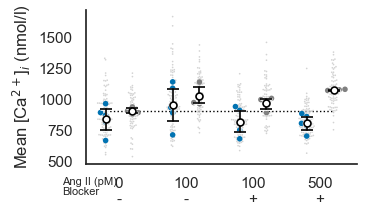

In [14]:
fig, g = plt.subplots(figsize=(3.5, 2))


data_1_v2 = data_1.groupby(["ctrl","recording", "pos"]).mean().reset_index()

var = "mean_ca_steady_state"


g = sns.swarmplot(x="pos", y=var, data=data_1_v2, s=4, zorder=3, hue="ctrl", hue_order=["n", "y"],
                  palette=[color_palette[0], "grey"], dodge=True)
g = sns.swarmplot(x="pos", y=var, data=data_1, s=1.2, zorder=1, hue="ctrl", hue_order=["n", "y"],  
                  palette=["lightgrey", "lightgrey"], dodge=True)


####################################
# manually dodge lineplot markers
data_1_v2["pos_mod_y"] = data_1_v2["pos"]-0.8
data_1_v2["pos_mod_n"] = data_1_v2["pos"]-1.2


####################################
sns.lineplot(x="pos_mod_y", y=var,data=data_1_v2,
              hue="ctrl",
              hue_order=["y"],
             lw=0,
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed, 
            zorder=10,  
            err_style="bars",
            err_kws=error_style,
            fillstyle="full", 
            **filled_marker_style)


sns.lineplot(x="pos_mod_n", y=var,data=data_1_v2,
              hue="ctrl",
              hue_order=["n"],
             lw=0,
              errorbar=("ci",95),
             n_boot=n_boot, seed=seed, 
            zorder=10,  
            err_style="bars",
            err_kws=error_style,
            fillstyle="full", 
            **filled_marker_style)



#####################################
sns.lineplot(x="pos_mod_y", y=var,data=data_1_v2,
              hue="ctrl",
              hue_order=["y"],
             lw=0,
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed, 
            zorder=5,  
            err_style="bars",
            err_kws=error_style_white,
            fillstyle="full", 
            **filled_marker_style_white)


sns.lineplot(x="pos_mod_n", y=var,data=data_1_v2,
              hue="ctrl",
              hue_order=["n"],
             lw=0,
              errorbar=("ci",95),
             n_boot=n_boot, seed=seed, 
            zorder=5,  
            err_style="bars",
            err_kws=error_style_white,
            fillstyle="full", 
            **filled_marker_style_white)



#####################################
plt.text(-0.85, 310, "Ang II (pM)", ha="left", size=8)
plt.text(-0.85, 230, "Blocker", ha="left", size=8)


g.spines['right'].set_visible(False)
g.spines['top'].set_visible(False)

plt.legend([],[], frameon=False)
g.set_xticklabels(["0\n-", "100\n-", "100\n+", "500\n+"])
#.set_yticks([1,2,3])
#g.set_ylim([350,1300])
g.set_ylabel("Mean [Ca$^{2+}$]$_i$ (nmol/l)")
g.set_xlabel("")

mean_pos1 = data_1_v2[(data_1_v2["pos"]==1) & (data_1_v2["ctrl"]=="y")]["mean_ca_steady_state"].mean()
g.hlines(mean_pos1,-0.2,3.2, color="black", ls=":", zorder=0, lw=1) 


plt.show()